We aim to create a system that can predict likely diagnoses from patient records and clinical notes by leveraging a BERT-based model (bert-base-cased). The process involves the following steps:

# Workflow:

1- Prepare and Clean the Data

2- Convert Text into Model-Readable Tokens

3- Train BERT to Predict Diagnoses

4- Assess Model Performance (using metrics like Confusion Matrix and Classification Report)

5- Save the Trained Model and Build the Prediction Pipeline

# 1. Prepare and Clean the Data
The text will be cleaned and the dataset preprocessed to ensure it is ready for training the model.

In [3]:
import pandas as pd

data = pd.read_csv("/clinical_notes_diagnosis_prediction_5000 (1).csv") #data taken from kaggle
data

,Clinical Notes,Diagnosis
0,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
1,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
2,A 50-year-old male with a history of diabetes ...,Septic Shock
3,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
4,A 55-year-old female with a history of obesity...,Type 2 Diabetes Mellitus
...,...,...
4995,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4996,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis
4997,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4998,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
data['Clinical Notes'][40]

'A 50-year-old male presents for a follow-up visit. He has a history of hypertension but has not been compliant with his medications. Blood pressure readings are consistently elevated at 160/100 mmHg. The patient is advised to follow a low-sodium diet and to take antihypertensive medications regularly. The patient is also referred to a cardiologist for further evaluation.'

In [5]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords') #downloading stopwords
stop_words = set(stopwords.words('english'))#loading them now
def textCleaning(text):
    text = str(text).lower() #converting to string and lowercase the text
    text = re.sub(r'\d+', '', text) #removing any numbers
    text = re.sub(r'[^a-z\s]', '', text) #removing special characters, punctuation and non-alphabetical characters
    text = re.sub(r'\s+', ' ', text).strip() #removing extra spaces
    text = ' '.join([word for word in text.split() if word not in stop_words])  #removing stopwords
    return text

data['Clinical Notes'] = data['Clinical Notes'].apply(textCleaning)
data.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
1,yearold male history heavy alcohol use present...,Liver Cirrhosis
2,yearold male history diabetes presents hypoten...,Septic Shock
3,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
4,yearold female history obesity hypertension pr...,Type 2 Diabetes Mellitus


In [6]:
data['Diagnosis'].value_counts()

,count
Diagnosis,
Peptic Ulcer Disease,284
Type 2 Diabetes Mellitus,283
Acute Myocardial Infarction,272
Chronic Obstructive Pulmonary Disease,269
Cerebrovascular Accident,263
Deep Vein Thrombosis,260
Community-Acquired Pneumonia,251
Chronic Kidney Disease,251
Septic Shock,246


In [7]:
from sklearn.preprocessing import LabelEncoder #label encoding for 'diagnosis' column
label_encoder = LabelEncoder()
data['Diagnosis'] = label_encoder.fit_transform(data['Diagnosis'])

# 2. Convert Text into Model-Readable Tokens
We will employ the BertTokenizer to convert the cleaned text into tokens that the model can understand.

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(data['Clinical Notes'], data['Diagnosis'], test_size=0.2)
#tokenizing
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
!pip install datasets

In [ ]:
from datasets import Dataset #converting to dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})
train_dataset[0]

# 3. Train BERT to Predict Diagnoses
A pre-trained BERT model will be adapted for multi-class classification by adding a classification layer on top to predict diagnoses.

In [13]:
#load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
#training arguments here
training_args = TrainingArguments(
    output_dir="./results",          #output directory for results
    eval_strategy="epoch",     #evaluate once per epoch
    save_strategy="epoch",          #save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              #learning rate
    per_device_train_batch_size=16,  #batch size for training
    per_device_eval_batch_size=16,   #batch size for evaluation
    num_train_epochs=5,              #increase number of epochs
    weight_decay=0.01,               #strength of weight decay
    logging_dir="./logs",            #directory for logging
    logging_steps=10,                #log every 10 steps
    lr_scheduler_type="linear",      #use linear learning rate scheduler with warmup
    warmup_steps=500,                #number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     #load the best model at the end of training
    metric_for_best_model="eval_loss", #monitor eval loss to determine the best model
    save_total_limit=3,              #limit the number of checkpoints to save
    gradient_accumulation_steps=2    #simulate larger batch size if GPU memory is limited
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)
trainer.train() #training here

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aykaimran28 (aykaimran28-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,2.404700,2.212608
2,1.054400,0.823036
3,0.169600,0.105683
4,0.036400,0.025862
5,0.024000,0.017614


TrainOutput(global_step=625, training_loss=1.0068819737911225, metrics={'train_runtime': 540.6468, 'train_samples_per_second': 36.993, 'train_steps_per_second': 1.156, 'total_flos': 668163381600000.0, 'train_loss': 1.0068819737911225, 'epoch': 5.0})

# 4. Assess Model Performance (using metrics like Confusion Matrix and Classification Report)
Once trained, the model’s performance will be assessed using a confusion matrix and a classification report.

Classification Report:
                                       precision    recall  f1-score   support

          Acute Myocardial Infarction       1.00      1.00      1.00        57
                  Acute Renal Failure       1.00      1.00      1.00        48
                               Asthma       1.00      1.00      1.00        53
             Cerebrovascular Accident       1.00      1.00      1.00        55
               Chronic Kidney Disease       1.00      1.00      1.00        45
Chronic Obstructive Pulmonary Disease       1.00      1.00      1.00        56
         Community-Acquired Pneumonia       1.00      1.00      1.00        55
             Congestive Heart Failure       1.00      1.00      1.00        51
                 Deep Vein Thrombosis       1.00      1.00      1.00        52
      Gastroesophageal Reflux Disease       1.00      1.00      1.00        40
                         Hypertension       1.00      1.00      1.00        41
                      Liver 

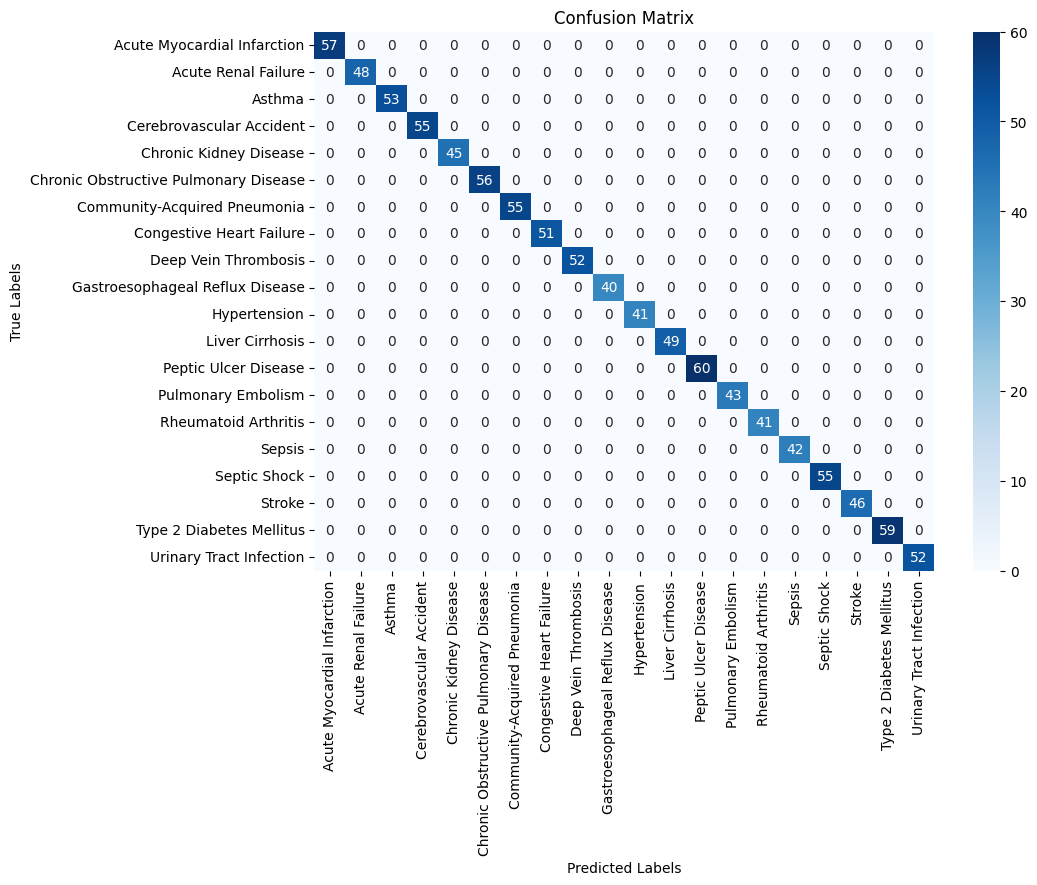

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predictions, labels, _ = trainer.predict(test_dataset)# predictions
predicted_labels = np.argmax(predictions, axis=1) # convert predictions to class labels

target_names = [str(label) for label in label_encoder.classes_] #make sure the 'label_encoder.classes_' are passed as string labels

print("classification report:")#print classification report
print(classification_report(test_labels, predicted_labels, target_names=target_names))

cmatrix = confusion_matrix(test_labels, predicted_labels)#confusion matrix

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 5. Save the Trained Model and Build the Prediction Pipeline
The trained model and tokenizer will be saved for future use.

In [15]:
trainer.save_model('./patient_model')
trainer.save_state()
tokenizer.save_pretrained('./patient_model')
import pickle
pickle.dump(label_encoder,open("label_encoder.pkl",'wb'))

In [16]:
from transformers import BertForSequenceClassification, BertTokenizer
import pickle
model = BertForSequenceClassification.from_pretrained('./patient_model')
tokenizer = BertTokenizer.from_pretrained('./patient_model')

with open("label_encoder.pkl", 'rb') as f:
    label_encoder = pickle.load(f)


In [22]:
import torch

def predictTheDisease(patient_record, model, tokenizer, label_encoder):
    inputs = tokenizer(patient_record, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    pred_label_index = torch.argmax(logits, dim=1).item()
    predicted_condition = label_encoder.inverse_transform([pred_label_index])[0]

    return predicted_condition


In [23]:
patient_record = "Patient presents with fever, headache, and fatigue. Medical history includes hypertension."
#make prediction for testing
predicted_disease = predictTheDisease(patient_record, model, tokenizer, label_encoder)
print(f"Predicted Disease: {predicted_disease}")
#should predict: Peptic Ulcer Disease

Predicted Disease: Peptic Ulcer Disease


In [19]:
patient_record = "'yearold male presents heartburn regurgitation sour taste mouth especially meals patient selfmedicating overthecounter antacids symptoms persist hour ph monitoring test confirms diagnosis gerd patient started ppi advised avoid trigger foods'"
predicted_disease = predictTheDisease(patient_record, model, tokenizer, label_encoder)

print(f"Predicted Disease: {predicted_disease}")
#should predict: Gastroesophageal Reflux Disease

Predicted Disease: Gastroesophageal Reflux Disease


# Download the zip folder of model

In [20]:
import shutil
from google.colab import files
shutil.make_archive('/content/patient_model', 'zip', './patient_model')
files.download('/content/patient_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>